# Minnesota potential

This notebook is dedicated to the Minnesota (MN) potential. It is meant to give the reader an idea how to use our software framework. It also creates the figures in the manuscript associated with this potential and more.

Let's import the Python modules:

In [212]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")
output_dir = "./output"

import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from ScatteringExp import ScatteringExp
from Grid import Grid

from scipy.special import factorial2, spherical_jn
from plots.rc_params import *
from string import ascii_lowercase as alphabet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualization of the potential (Figure 5)

Next, we set up the training and validation sets in the potential's two-dimensional parameter space:

In [213]:
from constants import hbarc, cm
channel = Channel(S=0, L=0, LL=0, J=0, channel=0)
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
potential = Potential(channel, **potentialArgs)
Vs_range =  (-200, 0) # (-400, 0)  #
VR_range = (100, 300) # (0, 400) # 
Vs_center = np.mean(Vs_range)
VR_center = np.mean(VR_range)
# seed = 124294784
# np.random.seed(seed)
param_samples = {
    "training": potential.getLecsSample({"V0": VR_range, "V1": Vs_range}, n=25, seed=None),
    "validation": potential.getLecsSample({"V0": VR_range, "V1": Vs_range}, n=1250, seed=None)
}

Let's now plot the Minnesota potential's (affine) parameter space and the associated potentials:

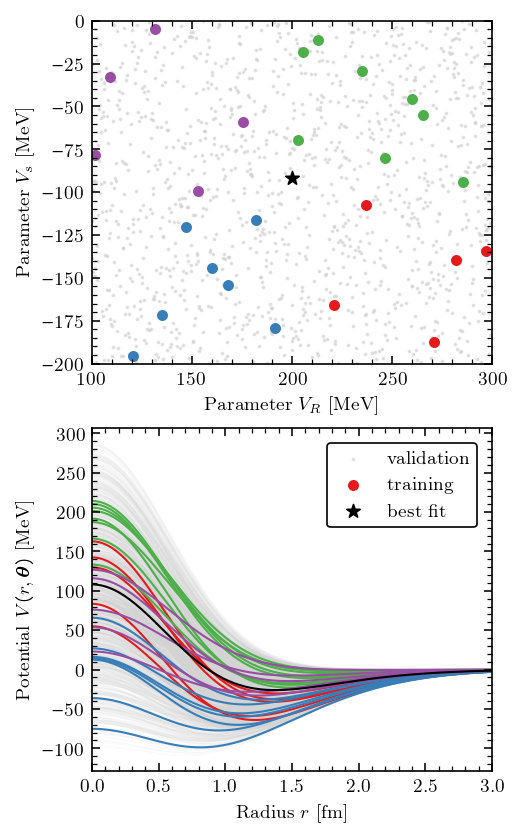

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(8.6*cm,14*cm), constrained_layout=True)
for index, lbl in enumerate(("validation", "training")):
    # randomly sample the 2d parameter space
    # we use 1250 random samples for validation and 25 for training
    param_samples_all = param_samples[lbl]
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    size_marker = [1, 20][index]
    size_line = [0.6, 1.0][index]
    alpha_lines = (0.1, 1.)[index]
        
    # left panel: parameter space
    masks = []
    masks.append(np.logical_and(param_samples_plot[:, 0] > VR_center, param_samples_plot[:, 1] < Vs_center))
    masks.append(np.logical_and(param_samples_plot[:, 0] < VR_center, param_samples_plot[:, 1] < Vs_center))
    masks.append(np.logical_and(param_samples_plot[:, 0] > VR_center, param_samples_plot[:, 1] > Vs_center))
    masks.append(np.logical_and(param_samples_plot[:, 0] < VR_center, param_samples_plot[:, 1] > Vs_center))
    
    if index == 1:
        alpha = 1 
        label = "training"
    else:
        alpha = 0.6
        label = "validation"

    for i_quadrant in range(4):
        color = colors[i_quadrant] if index == 1 else "lightgray"
        axs[0].scatter(param_samples_plot[masks[i_quadrant],0], param_samples_plot[masks[i_quadrant],1], 
                       alpha=alpha, color=color, s=size_marker, label=label if i_quadrant == 0 else "")

    # right panel: potential V(r)
    grid_plot = np.linspace(0, 4, 200)
    for i_quadrant in range(4): 
        mask = masks[i_quadrant]
        color = colors[i_quadrant] if index == 1 else "lightgray"
        add_lbl_to_legend = True if i_quadrant == 1 else False
        for ilec, lec_sample in enumerate(param_samples_all):
            if not mask[ilec]: 
                continue 
            if add_lbl_to_legend:
                label = ("validation", "training")[index]  
                add_lbl_to_legend = False
            else: 
                label = ""
            vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
            axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines, label=label)
        
# plot best_fit value
axs[0].scatter(potential.lecBaseValues["V0"], potential.lecBaseValues["V1"], 
               color="k", s=45, marker="*", label="best fit")
vr = hbarc * potential.eval(r=grid_plot, lecs=potential.lecBaseValues)
axs[1].plot(grid_plot, vr, color="k", lw=size_line, alpha=alpha_lines, label="MN potential")

# axis labels and more
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(*VR_range)
axs[0].set_ylim(*Vs_range)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
axs[1].legend(*axs[0].get_legend_handles_labels())
fig.savefig(f"{output_dir}/minnesota_parameter_space_quadrants.png", dpi=200)

Alternatively (not shown in the manuscript), here's a version without coloring the four quadrants:

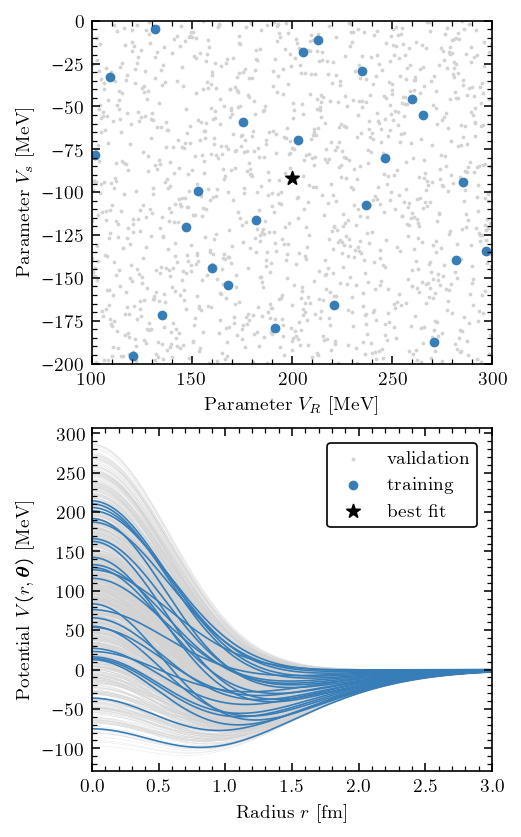

In [4]:
from constants import hbarc, cm
fig, axs = plt.subplots(2, 1, figsize=(8.6*cm,14*cm), constrained_layout=True)
np.random.seed(123)

for index, lbl in enumerate(("validation", "training")):
    param_samples_all = param_samples[lbl]
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    color = ("lightgray", colors[1])[index]
    size = [1, 15][index]
    axs[0].scatter(param_samples_plot[:,0], param_samples_plot[:,1], color=color, s=size, label=("validation", "training")[index])
    
    grid_plot = np.linspace(0, 4, 200)
    size = [1.2, 8][index]
    for lec_sample in param_samples_all:
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size/10)

axs[0].scatter(potential.lecBaseValues["V0"], 
               potential.lecBaseValues["V1"], color="k", s=45, marker="*", label="best fit")
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(*VR_range)
axs[0].set_ylim(*Vs_range)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
axs[1].legend(*axs[0].get_legend_handles_labels())
fig.savefig(f"{output_dir}/minnesota_parameter_space.png", dpi=200)

## Comparison with the Runge-Kutta adaptive FOM solver

Next, we study the emulator's accuracy at the wavefunction level. First, we need to specify the scattering experiment, including the partial-wave channel and energy:

In [5]:
l = 0
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

E_MeV = 100 # MeV
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

# generate training data
rmatch = 12
rmin = 1e-12 
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 

Next, we set up the RSE solvers and solve the RSE using the matrix Numerov method and RK45. Note that below one can specify whether to solve the homogeneous or inhomogeneous RSE. We choose the later.

phase shifts (Numerov vs. RK45): 3.0524194584417232 3.0524193563999993 1.0204172395944511e-07


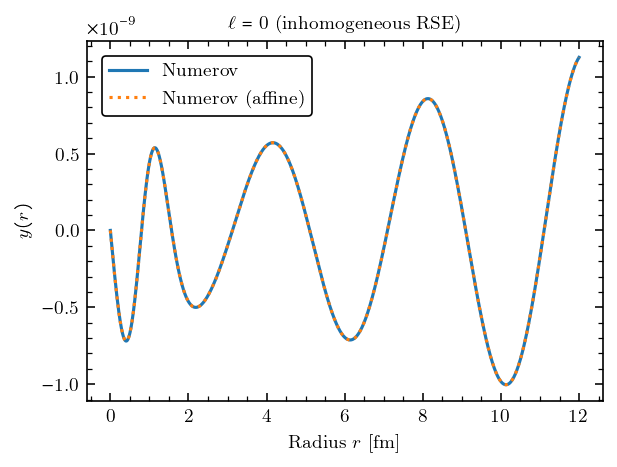

In [6]:
from RseSolver import RseSolver
solver = RseSolver(scattExp, grid, inhomogeneous=True)  # decide here whether to solve the homogeneous or inhomogeneous RSE
kwargs = dict(lecList=testingLecList, asympParam="K", matching=True)
scattSols_numerov_affine = solver.solve(method="Numerov_affine", **kwargs)
scattSols_numerov = solver.solve(method="Numerov", **kwargs)
scattSols_rk45 = solver.solve(method="RK45", **kwargs)

pr = grid.points * scattExp.p
plt.figure(figsize=(4,3))
plt.plot(grid.points, np.real(scattSols_numerov[0].u-scattSols_rk45[0].u), label="Numerov")
plt.plot(grid.points, np.real(scattSols_numerov_affine[0].u-scattSols_rk45[0].u), 
         ls=":", label="Numerov (affine)")
# plt.plot(grid.points, greedy_grom.simulate([[1,200, -91.85]])[:,0] - scattSols_rk45[0].u, label="Numerov")
plt.xlabel("Radius $r$ [fm]")
plt.ylabel("$y(r)$")
# plt.xlim(-0.1,0.1)
rse_lbl = "inhomogeneous" if solver.inhomogeneous else "homogeneous"
plt.title(f"$\\ell = {l}$ ({rse_lbl} RSE)")
plt.legend()

a = scattSols_numerov[0].Lmatrix.phaseShift
b = scattSols_rk45[0].Lmatrix.phaseShift
print("phase shifts (Numerov vs. RK45):", a, b, np.abs(a-b))

As one can see, the matrix Numerov method (FOM solver) reproduces well (see the overall small magnitude of the error) the wave function obtained with the adaptive RK45 method (also an FOM).

## Illustration of the greedy algorithm in 1D (Figure 6)

Our main class for emulation is `MatrixNumerovROM`. It supports various training and emulation approaches, including the POD and greedy algorithm. Let's get to know it.

Before we look more into the greedy algorithm, let's investigate the POD approach. Below we set up a G-ROM and an LSPG-ROM, both trained using the POD.

In [7]:
from NumerovEmulator import MatrixNumerovROM
inhomogeneous = True
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V1": Vs_range}, 
            num_snapshots_init=20, 
            num_snapshots_max=200, 
            approach="pod", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=3, 
            mode="linear",
            inhomogeneous=inhomogeneous,
            seed=10203
            )
pod_grom = MatrixNumerovROM(greedy_training_mode="grom", **args)
pod_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)
outp = pod_lspg.emulate([[1, 200, -91.85]], mode="lspg", which="all")
# outp = pod_grom.emulate([[1, 200, -91.85]], which="all")
# outp = pod_lspg.simulate([[1, 200, -91.85]], which="all")

using 7 out of 20 POD modes in total: compression rate is 65.0 %
POD[ Y ]: compression rate is 25.0 %; dim: (998, 18)
using 7 out of 20 POD modes in total: compression rate is 65.0 %
POD[ Y ]: compression rate is 25.0 %; dim: (998, 18)
emulating 'all' using 'lspg'


Note that the output tells us the number of dominant POD modes used and the corresponding compression rate. The POD's threshold is set by `pod_rcond`. The number of snapshots is set by `num_snapshots_init`.

It is important to note that the FOM solvers do not normalize the wave function such that the asymptotic limit parametrization (via the K matrix) is obtained. This matching has to be done in a postprocessing step.

We can use for this task the class `ScatteringSolution`:

In [8]:
from RseSolver import ScatteringSolution
scattSol = ScatteringSolution(scattExp=scattExp, 
                            vr=None,
                                grid=grid, 
                                f=outp[:,0], 
                                fprime=None,
                                f_lbl=("chi" if inhomogeneous else "u"),
                                anc=1./scattExp.p,
                                Llbl="K",
                                matching=True)
print("phase shift (deg):", scattSol.phaseShift)
print("K matrix:", scattSol.Lmatrix.valueAs("K"))


ValueError: when 1d, distances must match the length of the corresponding dimension

Likewise, we can let the emulator do the work, as described in the manuscript. Below is the output for the phase shift:

In [9]:
pod_lspg.emulate([[1, 200, -91.85]], which="delta")

emulating 'delta' using 'lspg'


array([3.05241945])

In [11]:
sim_delta = pod_grom.simulate([[1, 200, -91.85]], which="delta")
emu_delta = pod_grom.emulate([[1, 200, -91.85]], which="delta")
print("simulated phase shift (deg):", sim_delta)
print("emulated phase shift (deg):", emu_delta)
print("difference:", sim_delta - emu_delta)

emulating 'delta' using 'grom'
simulated phase shift (deg): [3.05241945]
emulated phase shift (deg): [3.05241945]
difference: [-5.76330095e-11]


As we can see, the emulator (here, the G-ROM) reproduces the scattering phase shift very well.

We can also look at the difference between the emulator's output for the wave function (as described in the manuscript) and the post-processed step up:

In [12]:
plt.plot(grid.points, pod_lspg.emulate([[1, 200, -91.85]], which="u")[:,0] - scattSol.u)
plt.ylabel("difference in wave function")
plt.xlabel("$r$")

emulating 'u' using 'lspg'


NameError: name 'scattSol' is not defined

## Demonstration of the greedy algorithm in 1D

Next, we demonstrate the the greedy iteration using the potential's dependence on the parameter $V_s$ (which is negative). 

We do this for both the G-ROM and the LSPG-ROM. 

### Training and exploration

First, we need to train the emulator. This can be relatively slow because we also compute the theoretical error bounds using the SVD of the FOM matrix. In practice, one would not do that in favor of the SCM, as discussed in the manuscript.

In [12]:
# from NumerovEmulator import MatrixNumerovROM
# grid = Grid(rmin, rmatch, numIntervals=1, 
#             numPointsPerInterval=1000,
#             type="linear", test=False) 
# args = dict(scattExp=scattExp, 
#             grid=grid, 
#             free_lecs={"V1": Vs_range}, 
#             num_snapshots_init=2, 
#             num_snapshots_max=200, 
#             approach="greedy", 
#             pod_rcond=1e-10, 
#             init_snapshot_lecs=None,
#             greedy_max_iter=4, 
#             mode="linear",
#             # inhomogeneous=False,
#             seed=734249391 # 10203
#             )
# greedy_grom = MatrixNumerovROM(greedy_training_mode="grom", **args)
# greedy_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)

Let's see how the G-ROM does at the potential's best-fit values:

In [13]:
# lecs_best_fit = [[1, 200, -91.85]]
# print(greedy_grom.simulate(lecs_best_fit, which="delta"))
# print(greedy_grom.emulate(lecs_best_fit, which="delta"))
# greedy_grom.simulate(lecs_best_fit, which="delta") - greedy_grom.emulate(lecs_best_fit, which="delta")

Let's see how the LSPG-ROM does at the potential's best-fit values:

In [14]:
# print(greedy_lspg.simulate(lecs_best_fit, which="delta"))
# print(greedy_lspg.emulate(lecs_best_fit, which="delta"))
# greedy_lspg.simulate(lecs_best_fit, which="delta") - greedy_lspg.emulate(lecs_best_fit, which="delta")

### Greedy algorithm in action

In [15]:
# from constants import cm
# mpl.rcParams['figure.constrained_layout.use'] = False
# num_iter = len(greedy_lspg.greedy_logging) - 1
# V0_arr = greedy_lspg.lec_all_samples[:,2]
# fig, axs = plt.subplots(num_iter, 3, sharex=True, sharey=True,
#                         figsize=(18*cm,16*cm), layout=None)
# axs = np.atleast_1d(axs)
# plt.subplots_adjust(left=0.07, right=0.99, 
#                     top=0.96, bottom=0.16, 
#                     wspace=0.1, hspace=0.1)
# for ax in axs[-1,:]:
#     ax.set_xlabel("$V_s$ [MeV]")
# for iax, ax in enumerate(axs[:,0]):
#     ax.set_ylabel(f"abs. errors (iteration \\#{iax})")
# for ax, title in zip(axs[0,:], ("$||\\boldsymbol{\\chi} - \\tilde{\\boldsymbol{\\chi}}||$ (G-ROM)", 
#                                 "$||\\boldsymbol{\\chi} - \\tilde{\\boldsymbol{\\chi}}||$ (LSPG-ROM)", 
#                                 r"$|\delta - \tilde{\delta}|$")):
#     ax.set_title(title)

# axs[0,0].set_ylim(1e-9, 1e3)

# for niter in range(num_iter):
#     for irom_lbl, rom_lbl in enumerate(("g-rom", "lspg-rom")): # "lspg")):
#         rom = greedy_grom if rom_lbl == "g-rom" else greedy_lspg
#         ax = axs[niter, irom_lbl]
#         [snapshot_idxs, fom_sol, emulated_sol, 
#         romErrors, realErrors, estErrBounds,
#         coercivity_constant, 
#         delta_rom, delta_fom, error_est_delta] = rom.greedy_logging[niter]
#         ax.semilogy(V0_arr, realErrors, label=f"true error")
#         ax.semilogy(V0_arr, romErrors, ls="-", label=f"estimated error")
#         ax.semilogy(V0_arr, coercivity_constant*romErrors, 
#                     ls="--", label=f"scaled estimated error")
        
#         ax.fill_between(V0_arr, estErrBounds[:,0], estErrBounds[:,1], 
#                         alpha=0.3, color='0.3',
#                         zorder=0, label="theoretical bounds")
        
#         for ierr, err in enumerate((romErrors, realErrors)):
#             label = "mean errors" if irom_lbl==0 and ierr == 0 else ""
#             ax.axhline(np.mean(err), ls=":", c='0.4', label=label)

#         for idx in snapshot_idxs:
#             ax.axvline(V0_arr[idx], c="k", alpha=0.5)

#         ax = axs[niter, 2]
#         delta_err_exact = np.abs(delta_fom-delta_rom)
#         color = colors[irom_lbl]
#         ax.semilogy(V0_arr, delta_err_exact, color=color, label=rom_lbl.upper())
#         if rom_lbl == "g-rom":
#             ax.axhline(np.mean(delta_err_exact), ls=":", c='0.4', label=label)

#         ax.semilogy(V0_arr, error_est_delta, color=color, ls="--", label=f"upper bound ({rom_lbl.upper()})")
#         if rom_lbl == "g-rom":
#             ax.axhline(np.mean(error_est_delta), ls=":", c='0.4', label=label)

#     for idx in snapshot_idxs:
#         axs[niter, 2].axvline(V0_arr[idx], c="k", alpha=0.5)
    
# axs[-1,0].legend(bbox_to_anchor =(0.38, 0.05), loc='center', ncol=2, 
#                     bbox_transform=fig.transFigure, fontsize=7)
# for iax, ax in enumerate(axs.flatten()):
#     ax.text(0.08, 0.05, f"({alphabet[iax]})", transform = ax.transAxes)
# # axs[0,0].legend(loc='lower left', ncol=4, bbox_to_anchor =(1.5,2.65))
# axs[-1,-1].legend(bbox_to_anchor =(0.82, 0.05), loc='center', ncol=1, 
#                     bbox_transform=fig.transFigure, fontsize=7)
# fig.savefig(f"greedy_MN_potential_1S0.pdf")

## Convergence analysis

In [13]:
from NumerovEmulator import MatrixNumerovROM
inhomogeneous = True
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 

In [14]:
args = dict(scattExp=scattExp, 
            grid=grid, 
            # free_lecs={"V1": Vs_range}, 
            num_snapshots_init=20, 
            num_snapshots_max=200,  # irrelevant for POD
            approach="pod", 
            pod_rcond=None, 
            init_snapshot_lecs=param_samples["training"],
            greedy_max_iter=3, 
            mode="random",
            inhomogeneous=inhomogeneous,
            verbose=False,
            seed=10203
            )

lecs_list = potential.lec_array_from_dict(param_samples["validation"])
outp_sim = scattExp.p / pod_grom.simulate(lecs_list, which="K")
res = []
for pod_num_modes in range(2, 9):
    pod_grom = MatrixNumerovROM(pod_num_modes=pod_num_modes, **args)
    outp_emu = scattExp.p / pod_grom.emulate(lecs_list, mode="grom", which="K")
    rel_err = np.abs((outp_sim-outp_emu)/outp_sim)
    res.append([pod_num_modes, 
                np.mean(rel_err), np.min(rel_err), np.max(rel_err)])
res = np.array(res)

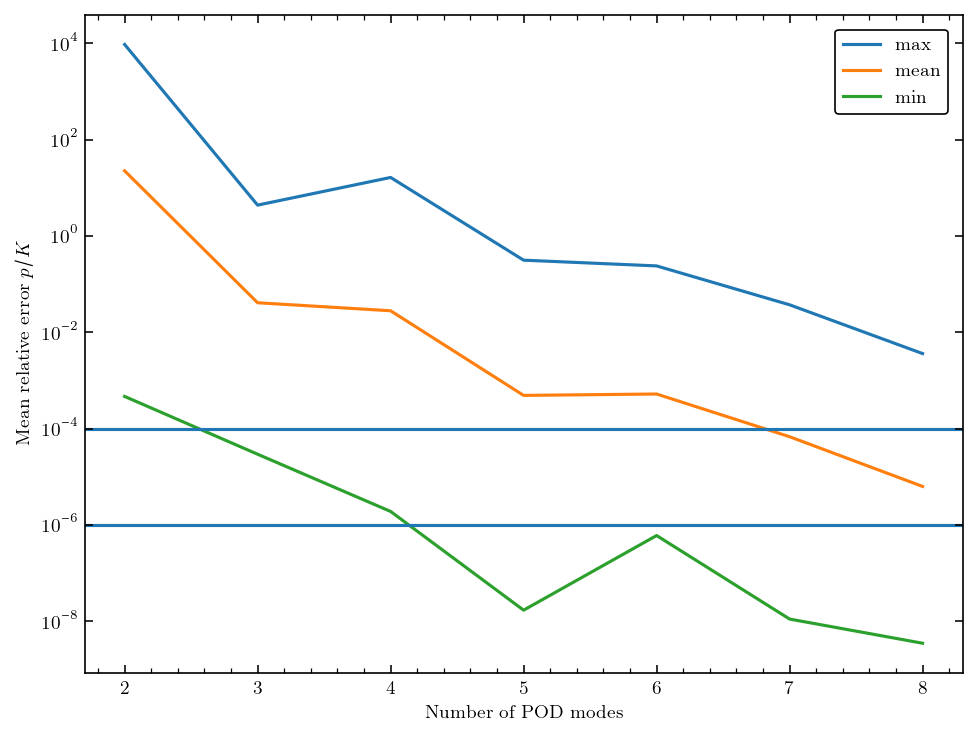

In [15]:
plt.semilogy(res[:,0], res[:,3], label="max")
plt.semilogy(res[:,0], res[:,1], label="mean")
plt.semilogy(res[:,0], res[:,2], label="min")
plt.axhline(1e-6)
plt.axhline(1e-4)
plt.xlabel("Number of POD modes")
plt.ylabel("Mean relative error $p / K$")
plt.legend()

In [16]:
lecs_list = potential.lec_array_from_dict(param_samples["validation"])
outp1 = pod_grom.emulate(lecs_list, which="delta")
outp2 = pod_grom.simulate(lecs_list, which="delta")
np.mean(np.abs((outp1-outp2)/outp1))

6.189792644398759e-06

In [17]:
from NumerovEmulator import MatrixNumerovROM
args = dict(scattExp=scattExp, 
            grid=grid, 
            # free_lecs={"V1": Vs_range}, 
            num_snapshots_init=2, 
            approach="greedy", 
            num_snapshots_max=2, 
            init_snapshot_lecs=param_samples["training"],
            greedy_max_iter=0, 
            mode="random",
            # inhomogeneous=False,
            seed=734249391 # 10203
            )
greedy_grom = MatrixNumerovROM(greedy_training_mode="grom", **args)
# greedy_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)

TypeError: MatrixNumerovROM.gram_schmidt() got multiple values for argument 'num_run'

## Next

In [21]:
# from NumerovEmulator import MatrixNumerovROM
# grid = Grid(rmin, rmatch, numIntervals=1, 
#             numPointsPerInterval=1000,
#             type="linear", test=False) 
# args = dict(scattExp=scattExp, 
#             grid=grid, 
#             free_lecs={"V0": VR_range, "V1": Vs_range}, 
#             num_snapshots_init=2, 
#             num_snapshots_max=8, 
#             approach="greedy", 
#             pod_rcond=1e-10, 
#             init_snapshot_lecs=None,
#             greedy_max_iter=4, 
#             mode="random",
#             # inhomogeneous=False,
#             verbose=False,
#             seed=734249391 # 10203
#             )
# greedy_grom = MatrixNumerovROM(greedy_training_mode="grom", **args)
# # greedy_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)

In [22]:
# greedy_grom.greedy_algorithm(req_num_iter=2)

In [18]:
# from NumerovEmulator import MatrixNumerovROM
# grid = Grid(rmin, rmatch, numIntervals=1, 
#             numPointsPerInterval=1000,
#             type="linear", test=False) 
# args = dict(scattExp=scattExp, 
#             grid=grid, 
#             free_lecs={"V0": VR_range, "V1": Vs_range}, 
#             num_snapshots_init=2, 
#             num_snapshots_max=8, 
#             approach="greedy", 
#             pod_rcond=1e-10, 
#             init_snapshot_lecs=None,
#             greedy_max_iter=8, 
#             mode="random",
#             # inhomogeneous=False,
#             verbose=False,
#             seed=734249391 # 10203
#             )
# greedy_grom2 = MatrixNumerovROM(greedy_training_mode="grom", **args)
# # greedy_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)

In [19]:
# np.allclose(greedy_grom2.snapshot_matrix, 
#             greedy_grom.snapshot_matrix, atol=1e-15, rtol=1e-15)

In [20]:
from NumerovEmulator import MatrixNumerovROM
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V0": VR_range, "V1": Vs_range}, 
            num_snapshots_init=6, 
            num_snapshots_max=8, 
            approach="orth", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=8, 
            mode="random",
            # inhomogeneous=False,
            verbose=False,
            seed=734249391 # 10203
            )
greedy_grom3 = MatrixNumerovROM(greedy_training_mode="grom", **args)
# greedy_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)

from NumerovEmulator import MatrixNumerovROM
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V0": VR_range, "V1": Vs_range}, 
            num_snapshots_init=6, 
            num_snapshots_max=8, 
            approach=None, 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=8, 
            mode="random",
            # inhomogeneous=False,
            verbose=False,
            seed=734249391 # 10203
            )
greedy_grom4 = MatrixNumerovROM(greedy_training_mode="grom", **args)
# greedy_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)

from NumerovEmulator import MatrixNumerovROM
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V0": VR_range, "V1": Vs_range}, 
            num_snapshots_init=6, 
            num_snapshots_max=8, 
            approach="pod", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=8, 
            mode="random",
            # inhomogeneous=False,
            verbose=False,
            seed=734249391 # 10203
            )
greedy_grom5 = MatrixNumerovROM(greedy_training_mode="grom", **args)
# greedy_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)

TypeError: MatrixNumerovROM.gram_schmidt() got multiple values for argument 'num_run'

In [21]:
val_set = potential.lec_array_from_dict(param_samples["validation"])

In [ ]:
a = greedy_grom3.emulate(val_set)
b = greedy_grom4.emulate(val_set)
c = greedy_grom5.emulate(val_set)
print(np.max(np.abs(a-b)))
print(np.max(np.abs(a-c)))

6.441798205969462e-10
0.0


In [28]:
# np.max(pod_emul.lec_all_samples, axis=0)

In [29]:
# np.min(pod_emul.lec_all_samples, axis=0)

In [649]:
snapshot_range = (2, 10+1)
emulator_type = "grom"
args = dict(scattExp=scattExp, 
            grid=grid, 
            # free_lecs={"V0": VR_range, "V1": Vs_range}, 
            # num_snapshots_max=25,  # irrelevant for POD
            pod_rcond=None, 
            init_snapshot_lecs=param_samples["training"],
            greedy_max_iter=0, 
            mode="random",
            inhomogeneous=inhomogeneous,
            verbose=False,
            seed=None
            )

lecs_list_validation = potential.lec_array_from_dict(param_samples["validation"])
lecs_list_training = potential.lec_array_from_dict(param_samples["training"])
outp_sim = pod_grom.simulate(lecs_list_validation, which="all")

def y_axis_quantity(outp_emu):
    x_emu = outp_emu
    x_sim = outp_sim
    # tmp = np.abs(2*(x_emu - x_sim)) / (np.abs(x_emu) + np.abs(x_sim))
    # tmp = np.abs((x_emu - x_sim) / x_sim)
    tmp = np.linalg.norm((x_emu - x_sim), axis=0)
    # tmp = 2*np.linalg.norm(x_emu- x_sim) / (np.linalg.norm(x_emu)+np.linalg.norm(x_sim))
    # tmp = np.linalg.norm(x_emu- x_sim) / np.linalg.norm(x_sim)
    return np.array([np.mean(tmp), np.min(tmp), np.max(tmp)])

# greedy_emul_arr = []
# for seed_val in (10203, 54872):
#     greedy_emul_arr.append(MatrixNumerovROM(num_snapshots_init=snapshot_range[0], 
#                                 approach="greedy", seed=seed_val, **args))

res = []
res2 = []
# num = 2 
for num_snapshots in range(*snapshot_range):  # [num]: # 
    current_res = [num_snapshots]
    # POD section
    pod_emul = MatrixNumerovROM(pod_num_modes=num_snapshots, 
                                # init_snapshot_lecs=param_samples["validation"],
                                num_snapshots_init=None, 
                                approach="pod", **args)
    current_res.extend(y_axis_quantity(pod_emul.emulate(lecs_list_validation, 
                                                        mode=emulator_type, which="all")))
    res2.append(pod_emul.fom_solutions)
    # # # greedy section
    # for iemu, emu in enumerate(greedy_emul_arr):
    #     current_res.extend(y_axis_quantity(emu.emulate(lecs_list_validation, mode=emulator_type, which="K")))
    #     emu.greedy_algorithm(req_num_iter=1)

    # orth section
    orth_emul = MatrixNumerovROM(num_snapshots_init=num_snapshots, # init_snapshot_lecs=param_samples["training"], 
                                # included_snapshots_idxs=idx,
                                approach="orth", **args)
    print(pod_emul.snapshot_matrix.shape)
    print(orth_emul.snapshot_matrix.shape)
    # print(pod_emul.included_snapshots_idxs)
    # print("\t", orth_emul.included_snapshots_idxs)
    # res2.append(orth_emul.fom_solutions)
    current_res.extend(y_axis_quantity(orth_emul.emulate(lecs_list_validation, 
                                                         mode=emulator_type, which="all")))
    res.append(current_res)
    print()
res = np.array(res)
print(orth_emul.included_snapshots_idxs)

(998, 2)
(998, 2)

(998, 3)
(998, 3)

(998, 4)
(998, 4)

(998, 5)
(998, 5)

(998, 6)
(998, 6)

(998, 7)
(998, 7)

(998, 8)
(998, 8)

(998, 9)
(998, 9)

(998, 10)
(998, 10)

{0, 3, 6, 7, 9, 10, 11, 12, 18, 21}


In [637]:
new_orth.snapshot_matrix - orth_emul.snapshot_matrix

array([[-8.18271517e-08, -1.73296055e-08],
       [-3.26443611e-07, -7.27110942e-08],
       [-8.13084787e-07, -1.93626079e-07],
       ...,
       [-5.35955146e-02,  7.19757059e-02],
       [-5.37363632e-02,  7.22540963e-02],
       [-5.38585030e-02,  7.25073309e-02]])

In [633]:
res[:, (0, 1, 4)]

array([[  2.        , 195.52036176,  15.20961654]])

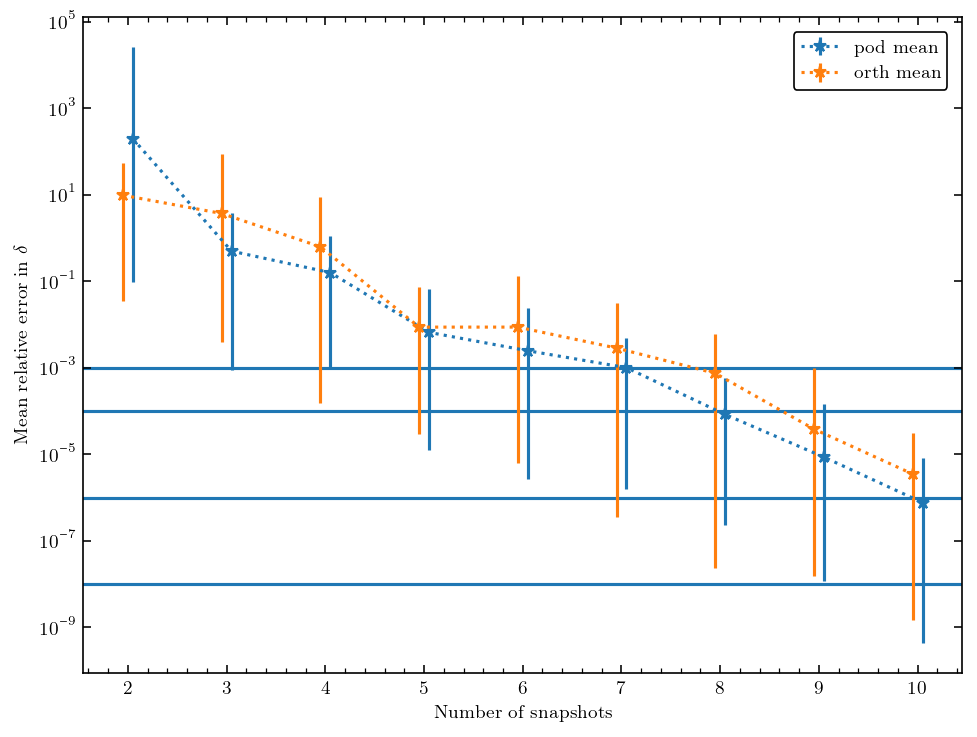

In [650]:
plt_args = {"ls": ":", "marker":"*"}
for i_emu_lbl, emu_lbl in enumerate(("pod", "orth")):
    offset = 3 * i_emu_lbl
    colors = color_list[i_emu_lbl]
    # plt.semilogy(res[:,0], res[:,3+offset], label=f"{emu_lbl} max", **plt_args)
    # plt.semilogy(res[:,0], res[:,1+offset], label=f"{emu_lbl} mean", **plt_args)
    plt.errorbar(res[:,0] + (-1)**i_emu_lbl * 0.05, res[:,1+offset], [res[:,1+offset]-res[:,2+offset], 
                                             res[:,3+offset]-res[:,2+offset]], 
                 label=f"{emu_lbl} mean", zorder=1000, **plt_args)
    # plt.semilogy(res[:,0], res[:,2+offset], label=f"{emu_lbl} min", **plt_args)

plt.yscale('log')
for elem in (1e-3, 1e-4, 1e-6, 1e-8):
    plt.axhline(elem)
plt.xlabel("Number of snapshots")
plt.ylabel(r"Mean relative error in $\delta$")
plt.legend()
# plt.ylim(bottom=1e-9)

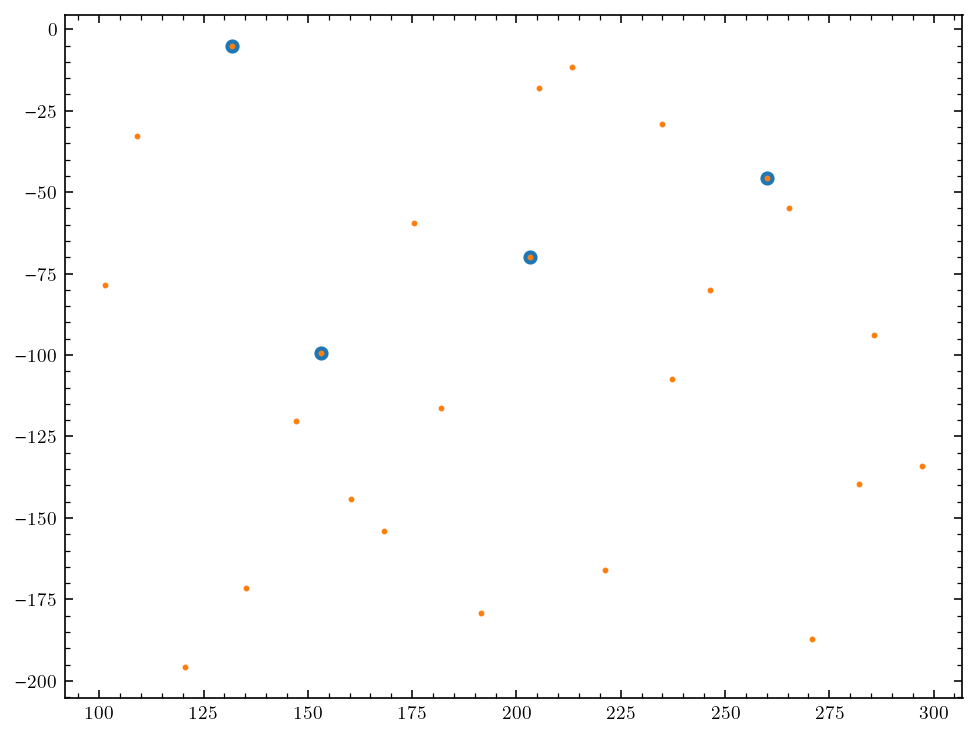

In [150]:
included_snapshot_idx = list(orth_emul.included_snapshots_idxs)
training_lecs = orth_emul.lec_all_samples[included_snapshot_idx]
all_trainging_lecs = potential.lec_array_from_dict(param_samples["training"])
plt.scatter(training_lecs[:,1], training_lecs[:,2])
plt.scatter(all_trainging_lecs[:,1], all_trainging_lecs[:,2], s=4)

In [124]:
xe

array([[9.25481949e-06, 3.57292725e-06],
       [3.69974966e-05, 1.42757724e-05],
       [9.24175428e-05, 3.56336993e-05],
       ...,
       [1.12548856e-01, 5.92634495e-01],
       [1.23157597e-01, 5.95570545e-01],
       [1.33723460e-01, 5.98299242e-01]])

In [128]:
training_lecs


array([[   1.        ,  282.09064683, -139.54641841],
       [   1.        ,  221.13119644, -166.07009192]])

using 25 out of 25 POD modes in total: compression rate is 0.0 %
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


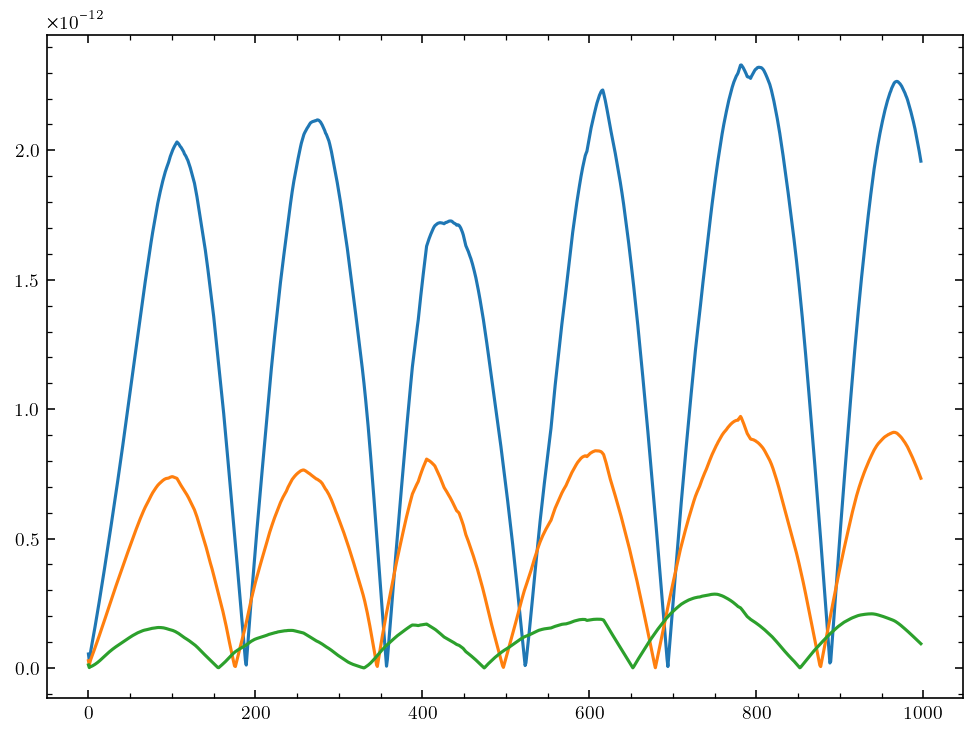

In [176]:
new_pod = MatrixNumerovROM(pod_num_modes=25, 
                            # init_snapshot_lecs=param_samples["validation"],
                            num_snapshots_init=25, 
                            approach="pod", **args)
xe = new_pod.emulate(training_lecs)
xs = new_pod.simulate(training_lecs)
diff = np.abs(xs - xe)
plt.plot(diff[:,0])
plt.plot(diff[:,1])
plt.plot(diff[:,2])
print(new_pod.included_snapshots_idxs)

In [177]:
training_lecs

array([[  1.        , 259.99213367, -45.69115338],
       [  1.        , 203.1433543 , -69.83052215],
       [  1.        , 153.15314483, -99.31982317],
       [  1.        , 131.77260039,  -5.00705808]])

In [165]:
orth_emul.included_snapshots_idxs

{0, 12, 18, 20}

In [169]:
training_lecs

array([[  1.        , 259.99213367, -45.69115338],
       [  1.        , 203.1433543 , -69.83052215],
       [  1.        , 153.15314483, -99.31982317],
       [  1.        , 131.77260039,  -5.00705808]])

In [175]:
new_pod.init_lecs

array([[   1.        ,  259.99213367,  -45.69115338],
       [   1.        ,  131.77260039,   -5.00705808],
       [   1.        ,  213.19026138,  -11.52554071],
       [   1.        ,  205.32592428,  -18.00617772],
       [   1.        ,  221.13119644, -166.07009192]])

{0, 1, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24}


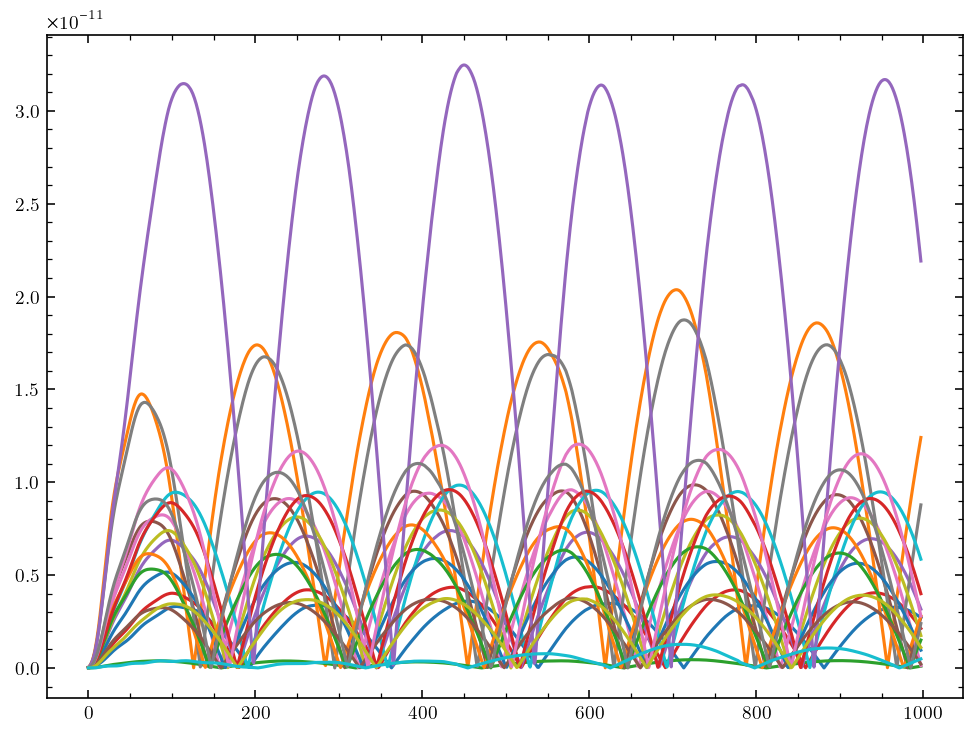

In [192]:
new_pod = MatrixNumerovROM(num_snapshots_init=20, 
                            approach="orth", **args)
xe = new_pod.emulate(new_pod.init_lecs)
xs = new_pod.simulate(new_pod.init_lecs)
diff = np.abs(xs - xe)
for i in range(len(new_pod.init_lecs)):
    plt.plot(diff[:,i])

print(new_pod.included_snapshots_idxs)

In [91]:
a_s = orth_emul.simulate(training_lecs, which="all") 
b_s = pod_emul.simulate(training_lecs, which="all")
c_s = orth_emul_gs.simulate(training_lecs, which="all")
np.max(np.abs(a_s - c_s))

0.0

In [615]:
from RseSolver import g, s
from Numerov import numerov

fom_calcs = []
for lecs in param_samples["training"]: # potential.get_lec_dict(training_lecs):
        ab_sparse, rhs, sol = numerov(grid.points, g=g, s=s, 
                y0=new_pod.numerov_solver.y0, 
                y1=new_pod.numerov_solver.y1, 
                params={**new_pod.rseParams, 
                        "lecs": lecs})
        
        fom_calcs.append(sol[2:])
fom_calcs = np.array(fom_calcs).T

# np.max(np.abs(res[2:,:] - pod_emul.simulate(training_lecs, which="all")))

# num = 5
res = []
for lecs in param_samples["validation"]: #potential.get_lec_dict(training_lecs): # param_samples["training"]:
        ab_sparse, rhs, sol = numerov(grid.points, g=g, s=s, 
                y0=new_pod.numerov_solver.y0, 
                y1=new_pod.numerov_solver.y1, 
                params={**new_pod.rseParams, 
                        "lecs": lecs})
        # snapshot_matrix, r = np.linalg.qr(snapshot_matrix)
        snapshot_matrix = orth(fom_calcs, rcond=0)[:,:num]
        # snapshot_matrix = new_pod.snapshot_matrix
        # print("pod", snapshot_matrix.shape)
        red_mat = snapshot_matrix.T @ ab_sparse.toarray() @ snapshot_matrix
        red_rhs = snapshot_matrix.T @ rhs 
        coeffs = np.linalg.solve(red_mat, red_rhs)
        emul_sol = snapshot_matrix @ coeffs        
        res.append(np.linalg.norm(np.abs(sol[2:]- emul_sol)))
        shape_s1 = snapshot_matrix.shape
res = np.array(res).T 

In [642]:
# idx = np.random.choice(range(len(param_samples["training"])), 
#                        size=num, replace=False)
idx = list(orth_emul.included_snapshots_idxs)
print(idx)
from scipy.linalg import orth, qr
snapshot_matrix = qr(fom_calcs[:,idx], mode='economic')[0]
res2 = []
for lecs in param_samples["validation"]: #potential.get_lec_dict(training_lecs): # param_samples["training"]:
        ab_sparse, rhs, sol = numerov(grid.points, g=g, s=s, 
                y0=new_pod.numerov_solver.y0, 
                y1=new_pod.numerov_solver.y1, 
                params={**new_pod.rseParams, 
                        "lecs": lecs})

        # print("orth", snapshot_matrix.shape)
        red_mat = snapshot_matrix.T @ ab_sparse.toarray() @ snapshot_matrix
        red_rhs = snapshot_matrix.T @ rhs 
        coeffs = np.linalg.solve(red_mat, red_rhs)
        emul_sol = snapshot_matrix @ coeffs        
        shape_s2 = snapshot_matrix.shape
        res2.append(np.linalg.norm(np.abs(sol[2:]- emul_sol)))
        assert shape_s1 == shape_s2, "snapshot matrices have wrong shape"
res2 = np.array(res2).T 

[18, 19]


In [643]:
new_pod = MatrixNumerovROM(pod_num_modes=num, 
                            # init_snapshot_lecs=param_samples["training"],
                            num_snapshots_init=25, 
                            approach="pod",
                            scattExp=scattExp, 
            grid=grid, 
            pod_rcond=None, 
            init_snapshot_lecs=param_samples["training"],
            greedy_max_iter=0, 
            mode="random",
            inhomogeneous=True,
            verbose=True,
            seed=32122345)
new_orth = MatrixNumerovROM(#pod_num_modes=num, 
                            # init_snapshot_lecs=param_samples["training"],
                            num_snapshots_init=num, 
                            included_snapshots_idxs=idx,
                            approach="orth",   
                            scattExp=scattExp,           
                            grid=grid, 
            pod_rcond=None, 
            init_snapshot_lecs=param_samples["training"],
            greedy_max_iter=0, 
            mode="random",
            inhomogeneous=True,
            verbose=True,
            seed=32122345)
# xe = new_pod.emulate(lecs_list_validation)
# xs = new_pod.simulate(lecs_list_validation)

# ye = new_orth.emulate(lecs_list_validation)
# ys = new_orth.simulate(lecs_list_validation)

# diff = np.abs(xs - xe)
# plt.plot(diff[:,0])
# plt.plot(diff[:,1])
# plt.plot(diff[:,2])
print(new_orth.included_snapshots_idxs)

using 2 out of 25 POD modes in total: compression rate is 92.0 %
POD[ Y ]: compression rate is 11.1 %; dim: (998, 8)
POD[ Y ]: compression rate is 33.3 %; dim: (998, 6)
[18, 19]


In [644]:
training_lecs = potential.lec_array_from_dict(param_samples["training"])
validation_lecs = potential.lec_array_from_dict(param_samples["validation"])

In [645]:
ye = new_pod.emulate(validation_lecs)
ys = new_pod.simulate(validation_lecs)
print(np.mean(np.linalg.norm(ye - ys, axis=0)))
print()

ye = new_orth.emulate(validation_lecs)
ys = new_orth.simulate(validation_lecs)
print(np.mean(np.linalg.norm(ye - ys, axis=0)))
print()

print(np.mean(np.abs(res)))
print(np.mean(np.abs(res2)))

emulating 'all' using 'grom'
195.5203617550647

emulating 'all' using 'grom'
15.209616539501862

3724.675453283179
15.209616539482795


In [646]:
np.max(np.abs(snapshot_matrix - new_orth.snapshot_matrix))

7.149489333890813e-14

In [505]:
np.max(np.abs(new_orth.simulate(training_lecs) - fom_calcs))

1.781103042830523e-12

In [502]:
np.max(np.abs(snapshot_matrix - new_pod.snapshot_matrix))
# np.max(np.abs(fom_calcs - new_pod.fom_solutions))

0.19255185647859818

In [503]:
assert snapshot_matrix.shape == new_pod.snapshot_matrix.shape, "first"
assert snapshot_matrix.shape == new_orth.snapshot_matrix.shape, "second"

In [478]:
print(np.mean(np.abs(res)))
print(np.mean(np.abs(res2)))

0.006561258884510857
16.14456378121594


In [338]:
print(np.linalg.norm(xs - xe))
print(np.linalg.norm(ys - ye))

0.030544503871817976
2.4296366054156824


In [ ]:
new_pod = MatrixNumerovROM(# init_snapshot_lecs=param_samples["validation"],, 
                            approach="pod", **args)

#### POD

In [92]:
a_e = orth_emul.emulate(training_lecs, mode="grom", which="all") 
b_e = pod_emul.emulate(training_lecs, mode="grom", which="all")
c_e = orth_emul_gs.emulate(training_lecs, mode="grom", which="all")
np.max(np.abs(a_e - c_e))

2.621482827536159e-06

In [93]:
print(np.max(np.abs(a_e - a_s)))
print(np.max(np.abs(b_e - b_s)))
print(np.max(np.abs(a_e - c_e)))

9.622302954426232e-13
17.74463610419861
2.621482827536159e-06


In [220]:
print(np.max(np.abs(orth_emul.snapshot_matrix.T @ orth_emul.snapshot_matrix - np.eye(8))))
print(np.max(np.abs(orth_emul_gs.snapshot_matrix.T @ orth_emul_gs.snapshot_matrix - np.eye(8))))

2.220446049250313e-15
2.220446049250313e-15


In [49]:
from scipy.linalg import orth
np.max(np.abs(orth(pod_emul.fom_solutions)[:,:8] - pod_emul.snapshot_matrix))

0.0

In [50]:
a_e = orth_emul.emulate(training_lecs, mode="grom", which="all") 
b_e = pod_emul.emulate(training_lecs, mode="grom", which="all")
np.max(np.abs(a_e - b_e))

7.247961439138528e-06

In [51]:
orth(pod_emul.fom_solutions).T @ orth(pod_emul.fom_solutions)

array([[ 1.00000000e+00, -7.63278329e-17, -5.55111512e-17,
        -9.71445147e-17,  5.81132364e-17, -3.55618313e-17,
         4.16333634e-17, -2.42861287e-17,  1.90819582e-16,
        -6.93889390e-18, -6.93889390e-17,  3.46944695e-17,
         2.39391840e-16],
       [-7.63278329e-17,  1.00000000e+00, -3.33066907e-16,
        -1.56125113e-17,  1.38777878e-17,  5.20417043e-17,
         4.85722573e-17,  5.20417043e-17, -2.60208521e-17,
        -2.68882139e-17,  3.90312782e-18, -2.38524478e-18,
         3.20923843e-17],
       [-5.55111512e-17, -3.33066907e-16,  1.00000000e+00,
        -9.54097912e-18,  1.19695920e-16, -4.59701721e-17,
         3.81639165e-17, -2.94902991e-17, -5.72458747e-17,
         3.29597460e-17,  5.03069808e-17, -8.50014503e-17,
        -9.54097912e-18],
       [-9.71445147e-17, -1.56125113e-17, -9.54097912e-18,
         1.00000000e+00, -3.24393290e-16,  4.46691295e-17,
         4.81656815e-17, -1.09287579e-16, -4.03323208e-17,
        -5.29090660e-17, -4.42354486e

In [ ]:
snapshot_matrix = gram_schmidt(orth_emul.fom_solutions)
orth_emul.numerov_solver.get_linear_system

In [52]:
orth_emul.snapshot_matrix.shape == pod_emul.snapshot_matrix.shape

True

In [98]:
np.allclose(orth_emul.fom_solutions, 
            pod_emul.fom_solutions[:,included_snapshot_idx], atol=1e-15, rtol=0.)

True

#### Rest

In [224]:
def gram_schmidt(A, num_run=4, mode="modified"):
    # generated using Google AI
    if mode=="modified":
        for i in range(num_run):
            n, m = A.shape
            Q = np.zeros((n, m), dtype=float)
            R = np.zeros((m, m), dtype=float)
            for i in range(m):
                R[i, i] = np.linalg.norm(A[:, i])
                Q[:, i] = A[:, i] / R[i, i]
                for j in range(i + 1, m):
                    R[i, j] = np.dot(Q[:, i].T, A[:, j])
                    A[:, j] = A[:, j] - R[i, j] * Q[:, i]
    else:  # regular Gram-Schmidt process
        for i in range(num_run):
            n = A.shape[1]
            Q = np.zeros_like(A, dtype=float)
            for j in range(n):
                v = A[:, j]
                for i in range(j):
                    q = Q[:, i]
                    v = v - np.dot(q, A[:, j]) * q
                Q[:, j] = v / np.linalg.norm(v)
    return Q


In [65]:
orth_emul.emulate(training_lecs, mode=emulator_type, which="delta")

array([ 12.90798914, -21.01377136,  41.14510288,  42.50640262,
        22.16058077, -28.77968686,  13.7568258 ,  53.06028805])

In [32]:
pod_emul.emulate(lecs_list_validation, mode="grom", which="u").shape

(1000, 1250)

In [33]:
a= pod_emul.emulate(lecs_list_validation, mode="grom", which="all")
b = pod_emul.simulate(lecs_list_validation, which="all")
np.max(np.linalg.norm(a-b, axis=0) / np.linalg.norm(b))

9.043847030875088e-11

In [34]:
pod_emul.emulate([lecs_list_validation[nn]], mode="grom", which="K") - pod_emul.simulate([lecs_list_validation[nn]], which="K")

NameError: name 'nn' is not defined

In [76]:
np.linalg.norm(pod_emul.emulate([lecs_list_validation[nn]], mode="grom", which="all") - pod_emul.simulate([lecs_list_validation[nn]]))

0.015211882286750867

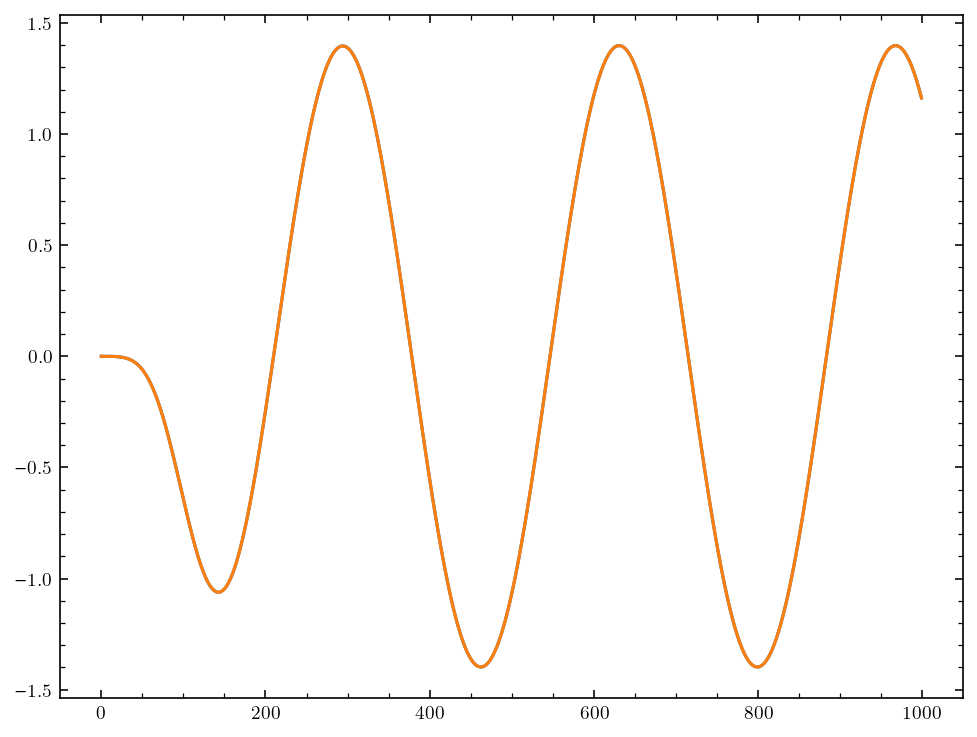

In [73]:
nn=1199
# plt.plot(pod_emul.emulate([lecs_list_validation[nn]], mode="grom", which="all") - pod_emul.simulate([lecs_list_validation[nn]], which="all"))
plt.plot(pod_emul.emulate([lecs_list_validation[nn]], mode="grom", which="all"))
plt.plot(pod_emul.simulate([lecs_list_validation[nn]], which="all"))

In [60]:
lecs_list_validation[1199]

array([   1.        ,  371.35662765, -386.9499499 ])

In [ ]:
lecs_list_validation

In [ ]:
np.argmax(np.linalg.norm(pod_emul.emulate(lecs_list_validation, mode="grom", which="u") - pod_emul.simulate(lecs_list_validation, which="u"), axis=0))

1199

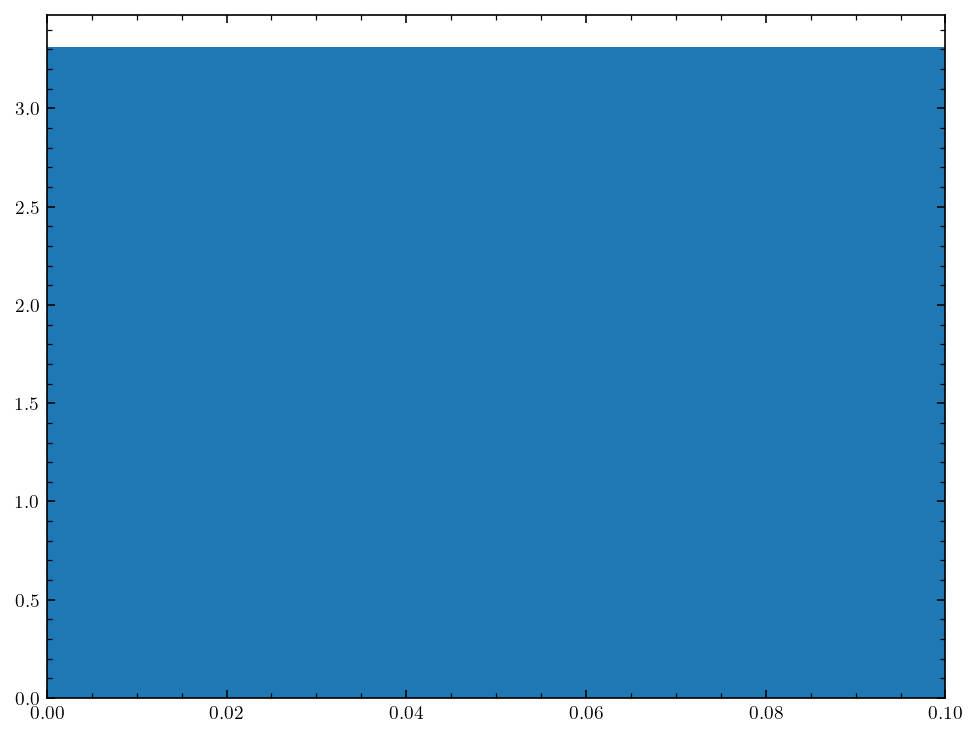

In [45]:

# plt.hist(, bins=1000, density=True)
# plt.xlim(0,0.1)
# np.argmax(np.abs(pod_emul.emulate(lecs_list_validation, mode="grom", which="K")-pod_emul.simulate(lecs_list_validation, which="K")))

In [32]:
# potential = Potential(channel, **potentialArgs)
# scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
# solver = RseSolver(scattExp, grid, inhomogeneous=inhomogeneous)
# solver_args = dict(asympParam="K", matching=True)
# lecs_list_training = potential.lec_array_from_dict(param_samples["training"])
# scattSols_numerov = solver.solve(lecList=lecs_list_training, 
#                                  method="RK45", **solver_args)
# # scattSols_rk45 = solver.solve(lecList=validationLecList, method="RK45", **solver_args)

In [33]:
# np.max(np.abs(np.array([elem.Lmatrix.K for elem in scattSols_numerov]) - pod_grom.simulate(lecs_list_training, which="K")))

In [ ]:
pod_grom.simulate(lecs_list_training, which="K")

NameError: name 'lecs_list_training' is not defined

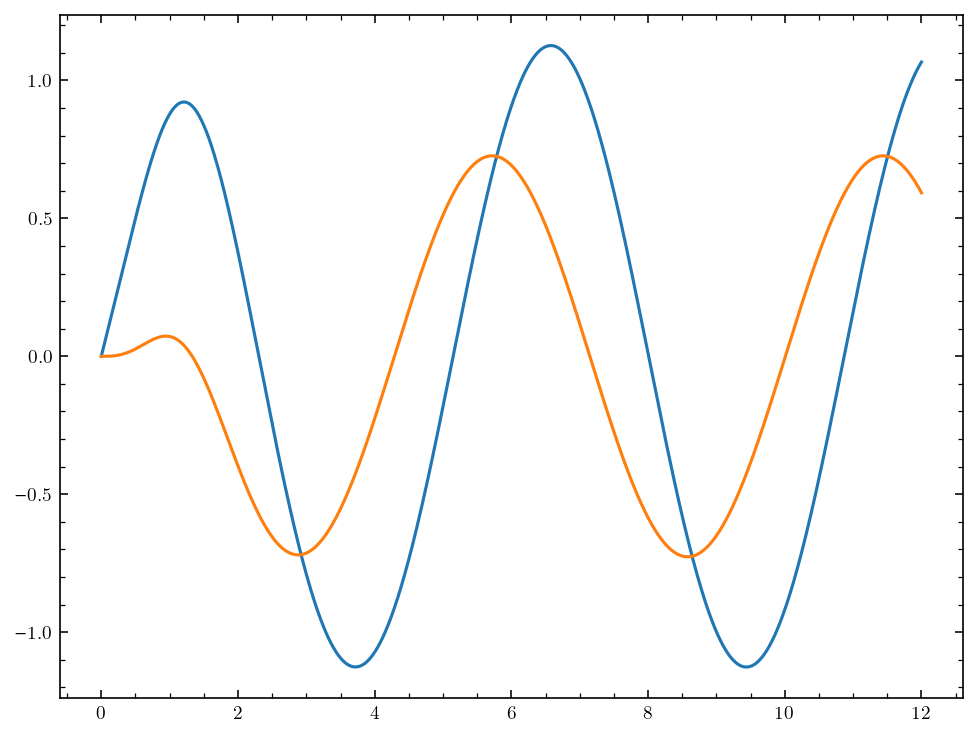

In [ ]:
outp_sim = pod_grom.simulate(lecs_list_training, which="all")
plt.plot(grid.points, scattSols_numerov[0].u)
plt.plot(grid.points, outp_sim[:,0])